In [295]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from math import sqrt

In [296]:
ratings = pd.read_csv("ratings_dataset.csv")
movies = pd.read_csv("Movie_Id_Titles.csv")
ratings.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [297]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [298]:
users = ratings["user_id"].unique()
users.shape

(944,)

## Build the movie recommender

In [299]:
train_data, test_data = train_test_split(ratings, test_size=.3, random_state=10)

In [300]:
class popularity_based_recommender_model():
    def __init__(self, train_data, test_data, user_id, item_id):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.item_id = item_id
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def fit(self):
        #Get a count of user_ids for each unique movie as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the movies based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(20)

    #Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id, n=5):    
        user_recommendations = self.popularity_recommendations
        
        #Filter movies that are not rated by the user
        movies_already_rated_by_user = self.train_data[self.train_data[self.user_id] == user_id][self.item_id]        
        user_recommendations = user_recommendations[~user_recommendations[self.item_id].isin(movies_already_rated_by_user)]
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols].head(n)   
        user_recommendations["movie_title"] = user_recommendations['item_id'].map(movies.set_index('item_id')['title'])
  
        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        sns.set_style("whitegrid")
        plt.figure(figsize=(20, 10))
        sns.set(font_scale=1.5)
        suggested_items = sns.barplot(x='score', y="movie_title", data=user_recommendations ,linewidth=1,edgecolor=".2",palette="Blues",saturation=1)
        suggested_items.set_title('List of the suggested movies based on their popularity')
        suggested_items.set(xlabel='Total rating', ylabel='Titles')
        plt.show()

        

        
    def predict_evaluate(self):        
        ratings = pd.DataFrame(self.train_data.groupby(self.item_id)['rating'].mean())
        
        pred_ratings = [];            
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)
        
        mse = mean_squared_error(self.test_data['rating'], pred_ratings)
        rmse = sqrt(mse)
        return rmse

In [301]:
popularity_recommender = popularity_based_recommender_model(train_data=train_data, test_data=test_data, user_id="user_id", item_id="item_id")

popularity_recommender.fit()

/var/folders/nk/l1f8p5td7p38z7qvp3bs4h7h0000gn/T/ipykernel_1454/1493994299.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['user_id'] = user_id


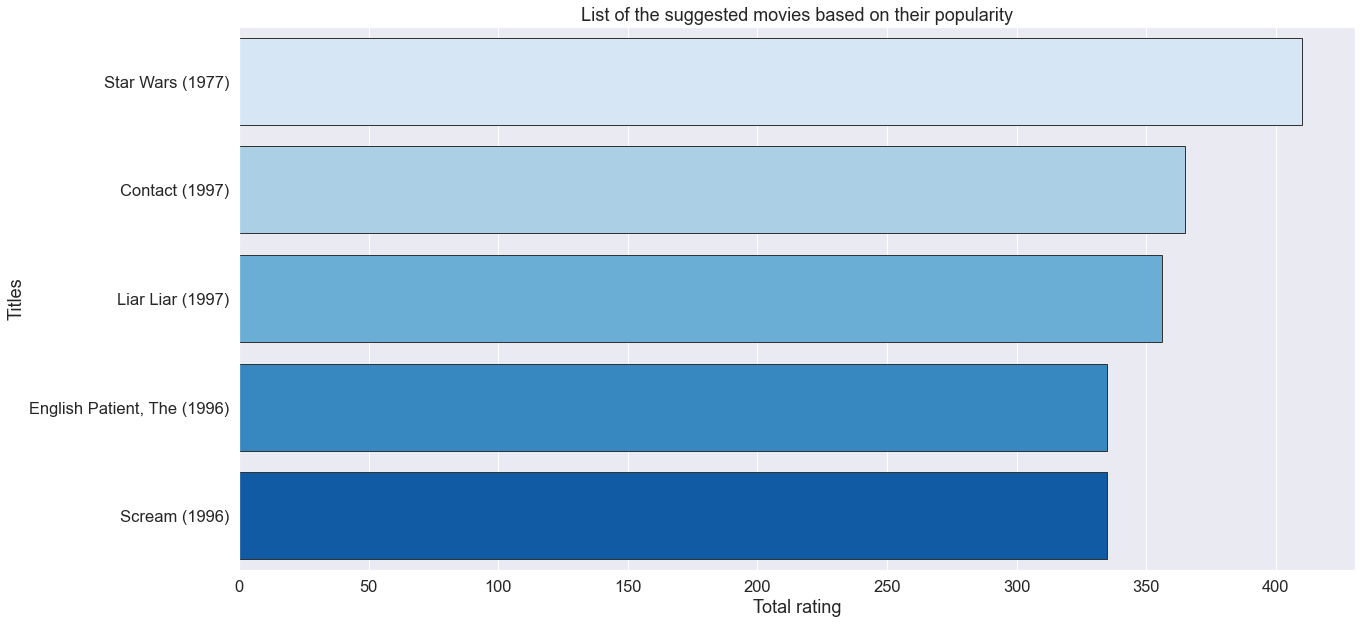

,user_id,item_id,score,Rank,movie_title
49,1,50,410,1.0,Star Wars (1977)
257,1,258,365,2.0,Contact (1997)
293,1,294,356,3.0,Liar Liar (1997)
285,1,286,335,6.0,"English Patient, The (1996)"
287,1,288,335,7.0,Scream (1996)


In [302]:
result_pop_user1 = popularity_recommender.recommend(1)
result_pop_user1

### Collaborative filtering based recommender

In [303]:
class collaborative_filtering_recommender_model():
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        self.recommendations = None
        self.user_item_matrix = None
        self.ratings = None
        
    #Create the popularity based recommender system model
    def fit(self):
        #Get a mean value for items based on user's ratings
        train_data_grouped = pd.DataFrame(train_data.groupby('item_id')['rating'].mean())
        train_data_grouped['rating_count'] = pd.DataFrame(train_data.groupby('item_id')['rating'].count())

        # Create factorization matrix
        user_movie_matrix = train_data.pivot_table(index='user_id', columns='item_id', values='rating')

        self.user_item_matrix = user_movie_matrix
        self.ratings = train_data_grouped

    #Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id, threshold = 30):    
        user_item_matrix = self.user_item_matrix
        ratings = self.ratings
        
        # Get user vector
        user_vector = user_item_matrix[user_id]

        # Calculate the correlation between user_vector and other vectors
        corr_matrix = user_item_matrix.corrwith(user_vector)
        corr_movies = pd.DataFrame(corr_matrix, columns=['correlation'])        
        corr_movies.dropna(inplace=True)

        corr_movies = corr_movies.join(ratings['rating_count'], how='left', lsuffix='_left', rsuffix='_right')
    
        user_recommendations = corr_movies[corr_movies['rating_count']>threshold].sort_values('correlation', ascending=False)
        user_recommendations["item_id"] = user_recommendations.index

        # #Sort the movies based upon recommendation score
        # train_data_sort = user_recommendations.sort_values(['correlation'], ascending = 0)

        user_recommendations = user_recommendations.query("correlation < 1")

        user_recommendations = user_recommendations.sort_values('correlation', ascending=0).head(5)
        user_recommendations["movie_title"] = user_recommendations['item_id'].map(movies.set_index('item_id')['title'])

        #Generate a recommendation rank based upon score
        user_recommendations['Rank'] = user_recommendations['correlation'].rank(ascending=0, method='first')

        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        sns.set_style("whitegrid")
        plt.figure(figsize=(20, 10))
        sns.set(font_scale=1.5)
        suggested_items = sns.barplot(x='correlation', y="movie_title", data=user_recommendations ,linewidth=1,edgecolor=".2",palette="Blues",saturation=1)
        suggested_items.set_title('List of the suggested movies based on collaboration filtering')
        suggested_items.set(xlabel='Correlation', ylabel='Titles')
        plt.show()

        

        
    def predict_evaluate(self):        
        ratings = pd.DataFrame(self.train_data.groupby('item_id')['rating'].mean())
        
        pred_ratings = [];            
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)
        
        mse = mean_squared_error(self.test_data['rating'].fillna(0), pred_ratings.fillna(0))
        rmse = sqrt(mse)
        return rmse

In [304]:
collaboration_filtering_recommender = collaborative_filtering_recommender_model(train_data=train_data, test_data=test_data)

collaboration_filtering_recommender.fit()

/opt/homebrew/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/homebrew/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


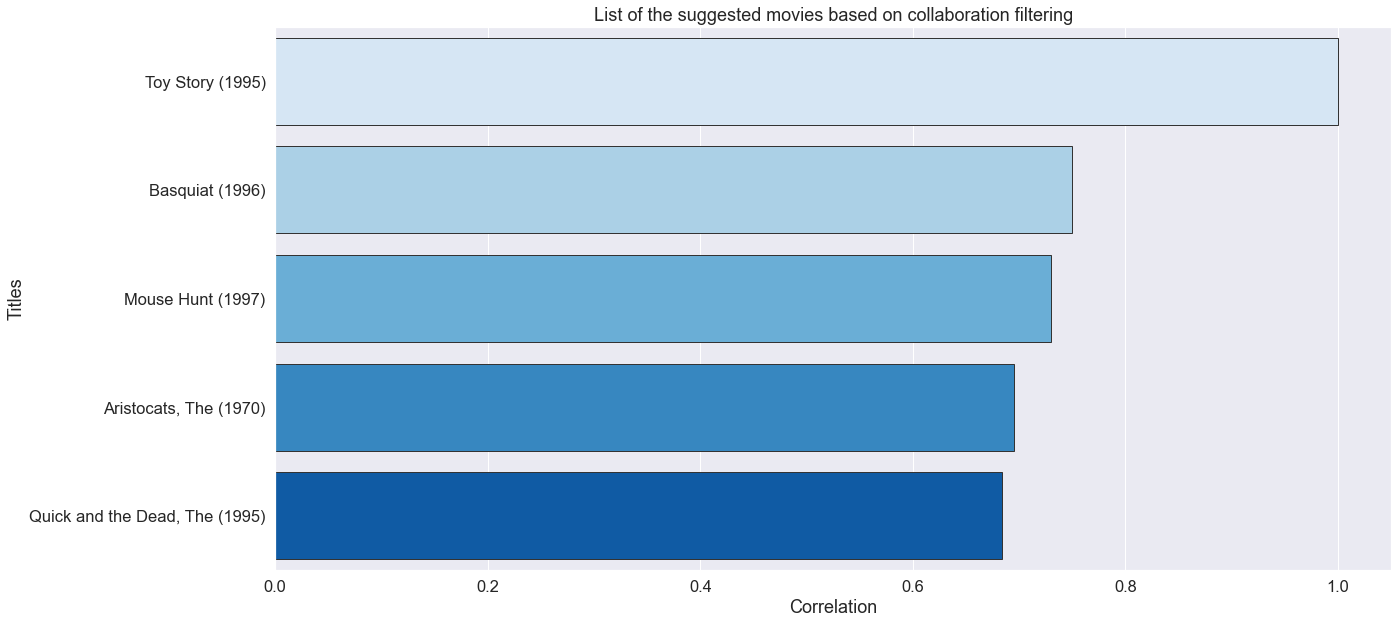

,correlation,rating_count,item_id,movie_title,Rank
item_id,,,,,
1,1.000000,311,1,Toy Story (1995),1.0
1010,0.749869,34,1010,Basquiat (1996),2.0
539,0.730341,36,539,Mouse Hunt (1997),3.0
102,0.695539,39,102,"Aristocats, The (1970)",4.0
562,0.683389,36,562,"Quick and the Dead, The (1995)",5.0


In [305]:
result_colab_user = collaboration_filtering_recommender.recommend(1)
result_colab_user